In [1]:
%load_ext autoreload
%autoreload 2

# 实验设计

我们将用MNIST数据集来做一个关于不同损失函数，不同采样方法的小实验，我们采用的Embedding Feature只有*二维*，虽然这在实际应用中往往欠妥，但是二维特征可以为我们的实验带来直观的可视化感受。

在所有的实验中，我们保持网络的尺寸不变(32 conv 5x5 -> PReLU -> MaxPool 2x2 -> 64 conv 5x5 -> PReLU -> MaxPool 2x2 -> Dense 256 -> PReLU -> Dense 256 -> PReLU -> Dense 2)，并且也不进行任何的调参 

# Prepare dataset
We'll be working on MNIST dataset

In [2]:
from torchvision.datasets import MNIST
from torchvision import transforms

mean, std = 0.1307, 0.3081

train_dataset = MNIST('../data/MNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = MNIST('../data/MNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))
n_classes = 10

## Common setup

In [3]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

# Baseline: Classification with softmax
We'll train the model for classification and use outputs of penultimate layer as embeddings

In [4]:
# Set up data loaders
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, ClassificationNet
from metrics import AccumulatedAccuracyMetric

embedding_net = EmbeddingNet()
model = ClassificationNet(embedding_net, n_classes=n_classes)
if cuda:
    model.cuda()
loss_fn = torch.nn.NLLLoss()
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [5]:
fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

Train: [0/60000 (0%)]	Loss: 2.345809	Accuracy: 9.375
Train: [12800/60000 (21%)]	Loss: 2.830935	Accuracy: 13.166360294117647
Train: [25600/60000 (43%)]	Loss: 1.554678	Accuracy: 25.645884900990097
Train: [38400/60000 (64%)]	Loss: 0.868793	Accuracy: 40.72588990066225
Train: [51200/60000 (85%)]	Loss: 0.521363	Accuracy: 52.52643034825871
Epoch: 1/20. Train set: Average loss: 1.2944	Accuracy: 58.275
Epoch: 1/20. Validation set: Average loss: 0.3316	Accuracy: 93.72
Train: [0/60000 (0%)]	Loss: 0.499486	Accuracy: 92.578125
Train: [12800/60000 (21%)]	Loss: 0.367083	Accuracy: 92.67003676470588
Train: [25600/60000 (43%)]	Loss: 0.278063	Accuracy: 93.68425123762377
Train: [38400/60000 (64%)]	Loss: 0.237062	Accuracy: 94.3501655629139
Train: [51200/60000 (85%)]	Loss: 0.234311	Accuracy: 94.65951492537313
Epoch: 2/20. Train set: Average loss: 0.2711	Accuracy: 94.84166666666667
Epoch: 2/20. Validation set: Average loss: 0.1548	Accuracy: 97.31
Train: [0/60000 (0%)]	Loss: 0.196208	Accuracy: 97.65625
Train:

Train: [38400/60000 (64%)]	Loss: 0.005069	Accuracy: 99.91463162251655
Train: [51200/60000 (85%)]	Loss: 0.004222	Accuracy: 99.92032027363184
Epoch: 18/20. Train set: Average loss: 0.0050	Accuracy: 99.91833333333334
Epoch: 18/20. Validation set: Average loss: 0.1133	Accuracy: 98.97
Train: [0/60000 (0%)]	Loss: 0.002547	Accuracy: 100.0
Train: [12800/60000 (21%)]	Loss: 0.004605	Accuracy: 99.9234068627451
Train: [25600/60000 (43%)]	Loss: 0.006127	Accuracy: 99.91104579207921
Train: [38400/60000 (64%)]	Loss: 0.004661	Accuracy: 99.91204470198676
Train: [51200/60000 (85%)]	Loss: 0.003622	Accuracy: 99.92226368159204
Epoch: 19/20. Train set: Average loss: 0.0048	Accuracy: 99.92333333333333
Epoch: 19/20. Validation set: Average loss: 0.1144	Accuracy: 98.99
Train: [0/60000 (0%)]	Loss: 0.001415	Accuracy: 100.0
Train: [12800/60000 (21%)]	Loss: 0.005616	Accuracy: 99.90042892156863
Train: [25600/60000 (43%)]	Loss: 0.004405	Accuracy: 99.92651608910892
Train: [38400/60000 (64%)]	Loss: 0.004589	Accuracy: 9

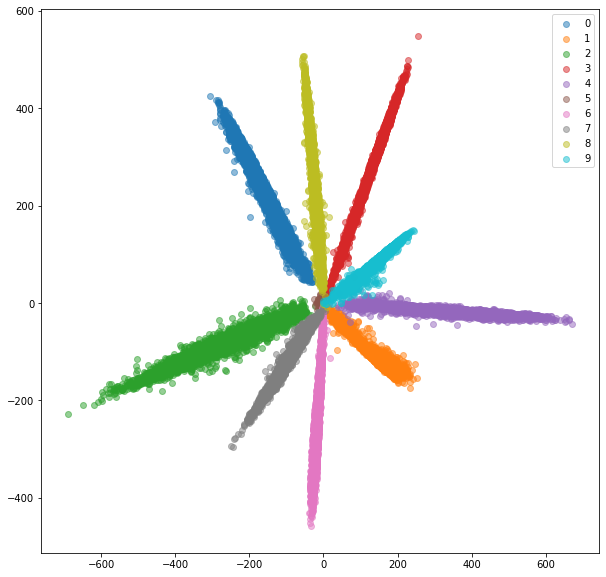

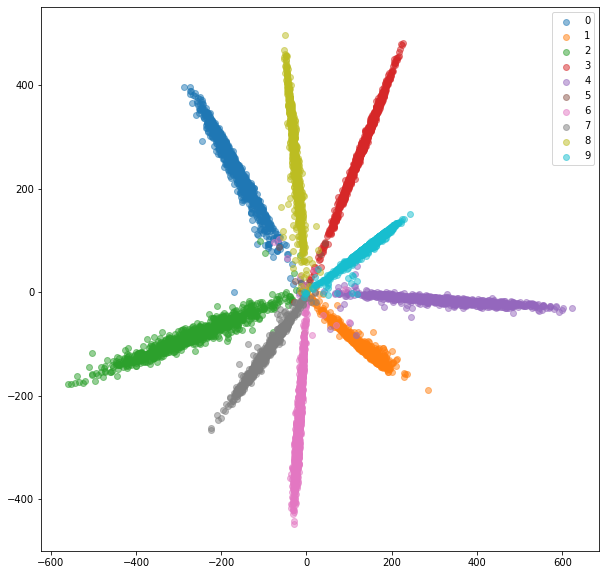

In [6]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

While the embeddings look separable (which is what we trained them for), they don't have good metric properties. They might not be the best choice as a descriptor for new classes.

# Siamese network
Now we'll train a siamese network that takes a pair of images and trains the embeddings so that the distance between them is minimized if their from the same class or greater than some margin value if they represent different classes.
We'll minimize a contrastive loss function*:
$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$

*Raia Hadsell, Sumit Chopra, Yann LeCun, [Dimensionality reduction by learning an invariant mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf), CVPR 2006*

In [7]:
# Set up data loaders
from datasets import SiameseMNIST

siamese_train_dataset = SiameseMNIST(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

D:\AI\Configuration\Anaconda3\envs\CV-ND\lib\site-packages\torchvision\datasets\mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
D:\AI\Configuration\Anaconda3\envs\CV-ND\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
D:\AI\Configuration\Anaconda3\envs\CV-ND\lib\site-packages\torchvision\datasets\mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
D:\AI\Configuration\Anaconda3\envs\CV-ND\lib\site-packages\torchvision\datasets\mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [ ]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.228683
Train: [12800/60000 (21%)]	Loss: 0.065878
Train: [25600/60000 (43%)]	Loss: 0.039363
Train: [38400/60000 (64%)]	Loss: 0.030309
Train: [51200/60000 (85%)]	Loss: 0.024058
Epoch: 1/20. Train set: Average loss: 0.0375
Epoch: 1/20. Validation set: Average loss: 0.0194
Train: [0/60000 (0%)]	Loss: 0.029085
Train: [12800/60000 (21%)]	Loss: 0.017285
Train: [25600/60000 (43%)]	Loss: 0.014928
Train: [38400/60000 (64%)]	Loss: 0.013476
Train: [51200/60000 (85%)]	Loss: 0.012437
Epoch: 2/20. Train set: Average loss: 0.0143
Epoch: 2/20. Validation set: Average loss: 0.0121
Train: [0/60000 (0%)]	Loss: 0.011002
Train: [12800/60000 (21%)]	Loss: 0.009022
Train: [25600/60000 (43%)]	Loss: 0.008750
Train: [38400/60000 (64%)]	Loss: 0.009666
Train: [51200/60000 (85%)]	Loss: 0.007438
Epoch: 3/20. Train set: Average loss: 0.0085
Epoch: 3/20. Validation set: Average loss: 0.0120
Train: [0/60000 (0%)]	Loss: 0.003452
Train: [12800/60000 (21%)]	Loss: 0.006682
Train: [25600/60000 (

In [ ]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)

# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

In [ ]:
# Set up data loaders
from datasets import TripletMNIST

triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, TripletNet
from losses import TripletLoss

margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [ ]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

In [ ]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)

# Online pair/triplet selection - negative mining
There are couple of problems with siamese and triplet networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

We can find some strategies on how to select triplets in [2] and [3] *Alexander Hermans, Lucas Beyer, Bastian Leibe, [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/pdf/1703.07737), 2017*

## Online pair selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **PairSelector** that takes embeddings and original labels and returns valid pairs within a minibatch
5. Define **OnlineContrastiveLoss** that will use a *PairSelector* and compute *ContrastiveLoss* on such pairs
6. Train the network!

In [ ]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [ ]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

In [ ]:
train_embeddings_ocl, train_labels_ocl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_ocl, train_labels_ocl)
val_embeddings_ocl, val_labels_ocl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_ocl, val_labels_ocl)

## Online triplet selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **TripletSelector** that takes embeddings and original labels and returns valid triplets within a minibatch
5. Define **OnlineTripletLoss** that will use a *TripletSelector* and compute *TripletLoss* on such pairs
6. Train the network!

In [ ]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [ ]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

In [ ]:
train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl)

In [ ]:
# display_emb_online, display_emb, display_label_online, display_label = train_embeddings_otl, train_embeddings_tl, train_labels_otl, train_labels_tl
display_emb_online, display_emb, display_label_online, display_label = val_embeddings_otl, val_embeddings_tl, val_labels_otl, val_labels_tl
x_lim = (np.min(display_emb_online[:,0]), np.max(display_emb_online[:,0]))
y_lim = (np.min(display_emb_online[:,1]), np.max(display_emb_online[:,1]))
plot_embeddings(display_emb, display_label, x_lim, y_lim)
plot_embeddings(display_emb_online, display_label_online, x_lim, y_lim)

In [ ]:
x_lim = (np.min(train_embeddings_ocl[:,0]), np.max(train_embeddings_ocl[:,0]))
y_lim = (np.min(train_embeddings_ocl[:,1]), np.max(train_embeddings_ocl[:,1]))
plot_embeddings(train_embeddings_cl, train_labels_cl, x_lim, y_lim)
plot_embeddings(train_embeddings_ocl, train_labels_ocl, x_lim, y_lim)